In [32]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [33]:
df = pd.read_csv("ambient_temperature_system_failure.csv")


In [34]:
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


In [35]:
df.info() # there is no any missing value in our Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [36]:
df['timestamp'].head()

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
Name: timestamp, dtype: object

In [37]:
df.describe().transpose() # describe only for numerical Values 

,count,mean,std,min,25%,50%,75%,max
value,7267.0,71.242433,4.247509,57.458406,68.369411,71.858493,74.430958,86.223213


In [38]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [39]:
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9

<AxesSubplot:xlabel='timestamp'>

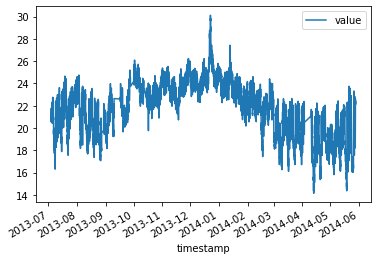

In [40]:
# plot 2 features 
df.plot(x='timestamp', y='value')

In [41]:
# Feature Engineering 
# adding useful Features
df['hours'] = df['timestamp'].dt.hour
# sunlight (morning) || Night
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int) # true 1 refer to morning

In [42]:
df

,timestamp,value,hours,daylight
0,2013-07-04 00:00:00,21.044908,0,0
1,2013-07-04 01:00:00,21.789015,1,0
2,2013-07-04 02:00:00,21.598781,2,0
3,2013-07-04 03:00:00,20.533000,3,0
4,2013-07-04 04:00:00,20.713084,4,0
...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1
7263,2014-05-28 12:00:00,22.318309,12,1
7264,2014-05-28 13:00:00,22.248092,13,1
7265,2014-05-28 14:00:00,22.125126,14,1


In [43]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [44]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay
0,2013-07-04 00:00:00,21.044908,0,0,3,1
1,2013-07-04 01:00:00,21.789015,1,0,3,1
2,2013-07-04 02:00:00,21.598781,2,0,3,1
3,2013-07-04 03:00:00,20.533000,3,0,3,1
4,2013-07-04 04:00:00,20.713084,4,0,3,1
...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1
7263,2014-05-28 12:00:00,22.318309,12,1,2,1
7264,2014-05-28 13:00:00,22.248092,13,1,2,1
7265,2014-05-28 14:00:00,22.125126,14,1,2,1


In [45]:
# astimation of the anomaly population of the data set 
outliers_fraction = 0.01

In [46]:
# time with int to plot easily.. converting time to Integer !!
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [47]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104
...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856


In [48]:
# add additional feature
df['categories'] = df['WeekDay']*2 + df['daylight']

In [49]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2
...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3


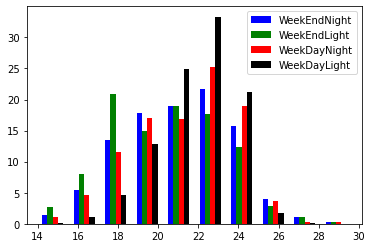

In [50]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()


In [51]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2
...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3


In [52]:
important_features = ['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']
from sklearn.preprocessing import StandardScaler, LabelEncoder

df[important_features] = StandardScaler().fit_transform(df[important_features])

In [56]:
data = df[important_features]

In [57]:
data

,value,hours,daylight,DayOfTheWeek,WeekDay
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132
...,...,...,...,...,...
7262,0.265532,-0.073523,0.706815,-0.499330,0.62132
7263,0.219090,0.070841,0.706815,-0.499330,0.62132
7264,0.189332,0.215206,0.706815,-0.499330,0.62132
7265,0.137218,0.359571,0.706815,-0.499330,0.62132


# Try Solving problem using Clustering

In [58]:
# reduce to 2 features using PCA 
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# you will get reduced features from 4- to 2 ....(unnamed features)

In [60]:
data = StandardScaler().fit_transform(data)
data

array([[ 0.0661908 ,  1.75536251],
       [-0.00941307,  1.64760941],
       [-0.00935887,  1.57767663],
       ...,
       [-0.6792709 , -0.36685803],
       [-0.68466375, -0.43951371],
       [-0.73415191, -0.53421197]])

In [62]:
# Cluster and celect number of clusters using Elbow Method
# n_cluster = range(1, 20)
# kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
# scores = [kmeans[i].score(data) for i in range(len(kmeans))]
# fig, ax = plt.subplots()
# ax.plot(n_cluster, scores)
# plt.show()

In [63]:
Kmeans = KMeans(n_clusters=15).fit(data) # we will use 15 Clster for this problem 

In [64]:
df['Cluster'] = Kmeans.predict(data)

In [66]:
df['principal_feature1'] = data[:,0]
df['principal_feature2'] = data[:,1]

In [67]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,Cluster,principal_feature1,principal_feature2
0,2013-07-04 00:00:00,-0.320586,-1.661537,-1.414798,0.005769,0.62132,13728960,2,7,0.066191,1.755363
1,2013-07-04 01:00:00,-0.005228,-1.517172,-1.414798,0.005769,0.62132,13728996,2,7,-0.009413,1.647609
2,2013-07-04 02:00:00,-0.085851,-1.372807,-1.414798,0.005769,0.62132,13729032,2,7,-0.009359,1.577677
3,2013-07-04 03:00:00,-0.537536,-1.228442,-1.414798,0.005769,0.62132,13729068,2,7,0.061592,1.543184
4,2013-07-04 04:00:00,-0.461215,-1.084077,-1.414798,0.005769,0.62132,13729104,2,7,0.031660,1.458262
...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,0.265532,-0.073523,0.706815,-0.499330,0.62132,14012748,3,9,-0.663130,-0.218870
7263,2014-05-28 12:00:00,0.219090,0.070841,0.706815,-0.499330,0.62132,14012784,3,1,-0.669607,-0.292067
7264,2014-05-28 13:00:00,0.189332,0.215206,0.706815,-0.499330,0.62132,14012820,3,1,-0.679271,-0.366858
7265,2014-05-28 14:00:00,0.137218,0.359571,0.706815,-0.499330,0.62132,14012856,3,1,-0.684664,-0.439514


In [69]:
df['Cluster'].value_counts()

4     739
6     672
7     590
9     589
3     582
10    578
1     574
14    569
2     432
13    358
5     350
11    350
8     338
12    308
0     238
Name: Cluster, dtype: int64

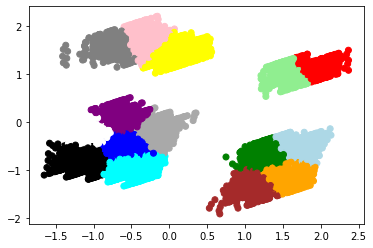

In [71]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["Cluster"].apply(lambda x: colors[x]))
plt.show()

In [72]:
# you can get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
# This is no the best way

In [75]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,Cluster,principal_feature1,principal_feature2
0,2013-07-04 00:00:00,-0.320586,-1.661537,-1.414798,0.005769,0.62132,13728960,2,7,0.066191,1.755363
1,2013-07-04 01:00:00,-0.005228,-1.517172,-1.414798,0.005769,0.62132,13728996,2,7,-0.009413,1.647609
2,2013-07-04 02:00:00,-0.085851,-1.372807,-1.414798,0.005769,0.62132,13729032,2,7,-0.009359,1.577677
3,2013-07-04 03:00:00,-0.537536,-1.228442,-1.414798,0.005769,0.62132,13729068,2,7,0.061592,1.543184
4,2013-07-04 04:00:00,-0.461215,-1.084077,-1.414798,0.005769,0.62132,13729104,2,7,0.031660,1.458262
...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,0.265532,-0.073523,0.706815,-0.499330,0.62132,14012748,3,9,-0.663130,-0.218870
7263,2014-05-28 12:00:00,0.219090,0.070841,0.706815,-0.499330,0.62132,14012784,3,1,-0.669607,-0.292067
7264,2014-05-28 13:00:00,0.189332,0.215206,0.706815,-0.499330,0.62132,14012820,3,1,-0.679271,-0.366858
7265,2014-05-28 14:00:00,0.137218,0.359571,0.706815,-0.499330,0.62132,14012856,3,1,-0.684664,-0.439514


# Usign Guassian distribution to solve Anomaly Detection

In [73]:

df_class0 = df.loc[df['categories'] == 0, 'value'] # all values belong to category 0
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

<AxesSubplot:>

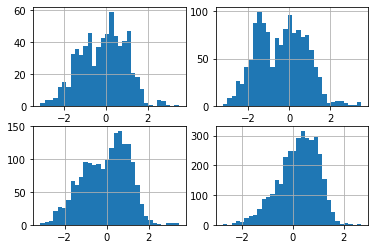

In [77]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [78]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction)  # 0.01 previously predefined
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train) # Predict labels (1 inlier, -1 outlier) of X according to fitted model

In [86]:
df_class0

,value,deviation,anomaly
48,0.091479,7.423475,1
49,-0.152028,7.443416,1
50,-0.091813,7.448915,1
51,-0.037122,7.447971,1
52,-0.093049,7.448871,1
...,...,...,...
7182,-2.262498,2.921150,1
7183,-2.024129,3.853658,1
7184,-2.090031,3.606588,1
7185,-2.422318,2.235786,1


In [80]:
# For rest 3 Features
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

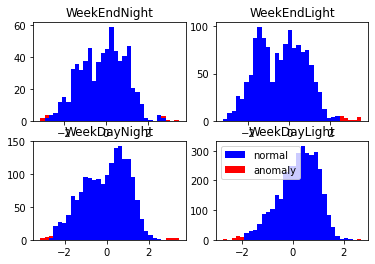

In [81]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [87]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

In [91]:
df_class

,value,deviation,anomaly
48,0.091479,7.423475,1
49,-0.152028,7.443416,1
50,-0.091813,7.448915,1
51,-0.037122,7.447971,1
52,-0.093049,7.448871,1
...,...,...,...
7262,0.265532,11.534784,1
7263,0.219090,11.520522,1
7264,0.189332,11.506120,1
7265,0.137218,11.470997,1


In [90]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,Cluster,principal_feature1,principal_feature2,anomaly22
0,2013-07-04 00:00:00,-0.320586,-1.661537,-1.414798,0.005769,0.62132,13728960,2,7,0.066191,1.755363,0
1,2013-07-04 01:00:00,-0.005228,-1.517172,-1.414798,0.005769,0.62132,13728996,2,7,-0.009413,1.647609,0
2,2013-07-04 02:00:00,-0.085851,-1.372807,-1.414798,0.005769,0.62132,13729032,2,7,-0.009359,1.577677,0
3,2013-07-04 03:00:00,-0.537536,-1.228442,-1.414798,0.005769,0.62132,13729068,2,7,0.061592,1.543184,0
4,2013-07-04 04:00:00,-0.461215,-1.084077,-1.414798,0.005769,0.62132,13729104,2,7,0.031660,1.458262,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,0.265532,-0.073523,0.706815,-0.499330,0.62132,14012748,3,9,-0.663130,-0.218870,0
7263,2014-05-28 12:00:00,0.219090,0.070841,0.706815,-0.499330,0.62132,14012784,3,1,-0.669607,-0.292067,0
7264,2014-05-28 13:00:00,0.189332,0.215206,0.706815,-0.499330,0.62132,14012820,3,1,-0.679271,-0.366858,0
7265,2014-05-28 14:00:00,0.137218,0.359571,0.706815,-0.499330,0.62132,14012856,3,1,-0.684664,-0.439514,0


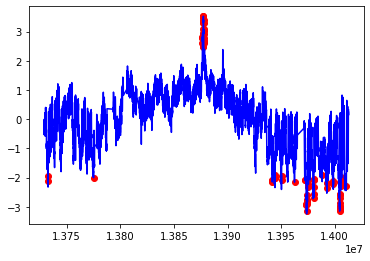

In [88]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red') # Outliers
plt.show()

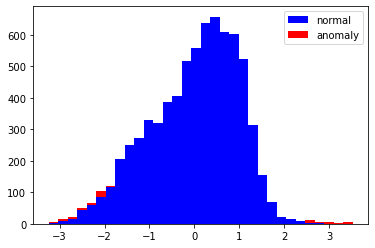

In [89]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()